MAE: 0.03, RMSE: 0.06, R2 Score: 0.99


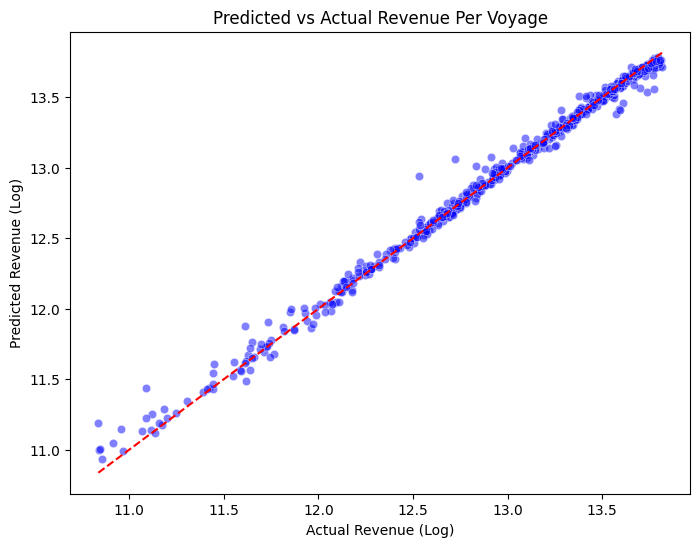

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Load Data
\
df = pd.read_csv("Ship.csv")

# Feature Engineering
df["Revenue_to_Cost_Ratio"] = df["Revenue_per_Voyage_USD"] / df["Operational_Cost_USD"]
df["Cargo_Efficiency"] = df["Cargo_Weight_tons"] / df["Distance_Traveled_nm"]
df["Log_Revenue"] = np.log1p(df["Revenue_per_Voyage_USD"])
df["Log_Cost"] = np.log1p(df["Operational_Cost_USD"])

# Handle Outliers
def cap_outliers(series):
    lower, upper = np.percentile(series, [1, 99])
    return np.clip(series, lower, upper)

for col in ["Revenue_per_Voyage_USD", "Operational_Cost_USD", "Cargo_Weight_tons", "Distance_Traveled_nm"]:
    df[col] = cap_outliers(df[col])

# Define Features & Target
selected_features = [
    "Cargo_Weight_tons", "Operational_Cost_USD", "Distance_Traveled_nm",
    "Turnaround_Time_hours", "Average_Load_Percentage", "Engine_Power_kW",
    "Efficiency_nm_per_kWh", "Weekly_Voyage_Count", "Ship_Type", "Route_Type",
    "Engine_Type", "Maintenance_Status", "Weather_Condition",
    "Revenue_to_Cost_Ratio", "Cargo_Efficiency", "Log_Cost"
]
target = "Log_Revenue"

X = df[selected_features]
y = df[target]

# Handle Categorical Variables
categorical_cols = ["Ship_Type", "Route_Type", "Engine_Type", "Maintenance_Status", "Weather_Condition"]
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Handle Missing Values
imputer = SimpleImputer(strategy="mean")
X_encoded = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=1)
rf_model.fit(X_train, y_train)
import joblib
joblib.dump(rf_model, "model7.joblib")
# with open("model7.pkl", "wb") as f:
#     pickle.dump(rf_model, f)
with open("scaler7.pkl", "wb") as f:
    pickle.dump(imputer, f)
with open("training_columns7.pkl", "wb") as f:
    pickle.dump(X_encoded.columns.tolist(), f)


# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2:.2f}")


# Visualization: Predictions vs. Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Identity line
plt.xlabel("Actual Revenue (Log)")
plt.ylabel("Predicted Revenue (Log)")
plt.title("Predicted vs Actual Revenue Per Voyage")
plt.show()
